In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
from sklearn import preprocessing
import numpy as np
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
tf.random.set_seed(13)
pd.options.display.max_rows = 8


import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
import numpy as np
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, Callback

np.random.seed(4)
#from tensorflow import set_random_seed
tf.random.set_seed(4)
#from util import csv_to_dataset, history_points


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50

def csv_to_dataset1(csv_path):
    dataf = pd.read_csv(csv_path)
    dataf.columns="date open high low close volume".split()
    dataf = dataf.drop('date', axis=1)
    col='open'
    dataf[f'{col}_diff1'] = dataf[col] - dataf[col].shift(1)
    dataf.dropna(inplace=True)
    
    data = dataf.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    n1 = len(data_normalised) - history_points
    
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points] for i in range(n1)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points] for i in range(n1)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    
    next_day_open_values_normalised = (data_normalised[:,0][history_points:]).reshape(-1,1)

    next_day_open_values=(data[:,0])[history_points:].reshape(-1,1)

    yn = preprocessing.MinMaxScaler()
    yn.fit(next_day_open_values)


    ti = np.array([0]*len(next_day_open_values_normalised))

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]
    return ohlcv_histories_normalised, ti, next_day_open_values_normalised, next_day_open_values, yn

ohlcv_histories1, _, next_day_open_values1, unscaled_y1, _ = csv_to_dataset1('MSFT_daily.csv')


In [4]:
'''a1=np.all(ohlcv_histories1 == ohlcv_histories)
a2=np.all(next_day_open_values1 == next_day_open_values)
a3=np.all(unscaled_y1 == unscaled_y)

assert a1 and a2 and a3, "Something is not right!!!"
ohlcv_histories1.shape, next_day_open_values1.shape, unscaled_y1.shape''';

In [43]:
##SADA
csv_path="MSFT_daily.csv"
data = pd.read_csv(csv_path)
data.columns="date open high low close volume".split()
col='open'
data[f'{col}_diff1'] = data[col] - data[col].shift(1)
data.dropna(inplace=True)

#scaler = preprocessing.StandardScaler()
#datan  = scaler.fit_transform(data[data.columns[1:]])
scaler = preprocessing.MinMaxScaler()
datan  = scaler.fit_transform(data[data.columns[1:]])

tsParams1 = {'length': history_points, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1, "shuffle":0 }
tsParams2 = {'length': history_points, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1, "shuffle":0 }
trng    = TimeseriesGenerator(datan, datan[:,0].reshape(-1,1), **tsParams1 )

ohlcv_histories2 = np.array([trng[i][0][0] for i in range(len(trng))])
next_day_open_values2 = np.array([trng[i][1][0] for i in range(len(trng))])
unscaled_y2 = (data.values[:,1])[history_points:].reshape(-1,1)


n1 = int(len(datan) * .9)
n2 = int(len(datan) * 1.)
ou = datan[:,0]
trng1 = TimeseriesGenerator(datan[:n2], ou[:n2], **tsParams1 )
valg1 = TimeseriesGenerator(datan[n1:], ou[n1:], **tsParams2 )

ohlcv_histories2.shape, next_day_open_values2.shape, unscaled_y2.shape

((4982, 50, 6), (4982, 1), (4982, 1))

In [44]:
a1=np.all(ohlcv_histories1 == ohlcv_histories2)
a2=np.all(next_day_open_values1 == next_day_open_values2)
a3=np.all(unscaled_y1 == unscaled_y2)
#assert a1 and a2 and a3, "Something is not right!!!"
a1, a2, a3

(True, True, True)

In [7]:
def getmodel(nfeatures):
    lstm_input = Input(shape=(history_points, nfeatures), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(1, name='dense_1')(x)
    output = Activation('linear', name='linear_output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    
    return model

#model_1 = getmodel(ohlcv_histories1.shape[-1])
model_2 = getmodel(ohlcv_histories1.shape[-1])
model_3 = getmodel(ohlcv_histories1.shape[-1])
model_4 = getmodel(ohlcv_histories1.shape[-1])

In [8]:
'''xx1=ohlcv_histories
yy1=next_day_open_values
epochs=1
vv=1

model_1.fit(x=xx1, y=yy1, verbose=vv,batch_size=32, epochs=epochs, shuffle=True, validation_split=0.1)
model_1.save(f'simple-1.h5')''';

In [29]:
epochs=1
vv=1
xx2=ohlcv_histories1
yy2=next_day_open_values1

model_2.fit(x=xx2, y=yy2, verbose=vv, batch_size=32, epochs=epochs, shuffle=True, validation_split=0.1)
model_2.save(f'simple1-2.h5')

Train on 4483 samples, validate on 499 samples
Epoch 1/1
4483/4483 [==============================] - 2s 439us/step - loss: 8.2888e-05 - val_loss: 1.8787e-04


In [46]:
xx3=ohlcv_histories2
yy3=next_day_open_values2

model_3.fit(x=xx3, y=yy3, verbose=vv, batch_size=32, epochs=epochs, validation_split=0.1)
model_3.save(f'simple1-3.h5')

Train on 4483 samples, validate on 499 samples
Epoch 1/1
4483/4483 [==============================] - 2s 463us/step - loss: 7.7258e-05 - val_loss: 2.8246e-04


In [37]:
if ("cp" not in globals()):
    print("Creating the ModelCheckpoint")
    cp = ModelCheckpoint(filepath="simple1-4.h5", monitor='val_loss', save_best_only=True, verbose=1)
model_4.fit(trng1, verbose=vv, epochs=1, validation_data=valg1,steps_per_epoch=200, shuffle=True, validation_steps=50,
               callbacks=[cp])


Epoch 1/1
200/200 [==============================] - 2s 11ms/step - loss: 2.8335e-04 - val_loss: 0.0011

Epoch 00001: val_loss did not improve from 0.0000006


In [15]:
def plot(model, valg, n=-150):
    dd='/opt/LMCO/git/notebooks/no-git/NNBook/notebooks/NNetworks/LSTM/new'
    m1 = load_model(f'{dd}/simple1-{model}.h5')
    
    xxt = np.array([valg[i][0][0] for i in range(len(valg))])
    yyt = np.array([valg[i][1][0] for i in range(len(valg))])

    plt.gcf().set_size_inches(22, 10, forward=True)
    yh=m1.predict(xxt)
    plt.plot(yyt[n:], marker='o', label="original")
    plt.plot(yh[n:], marker='x', label="predicted")
    plt.title(f"{model} <==")
    plt.legend()
    plt.show()
    

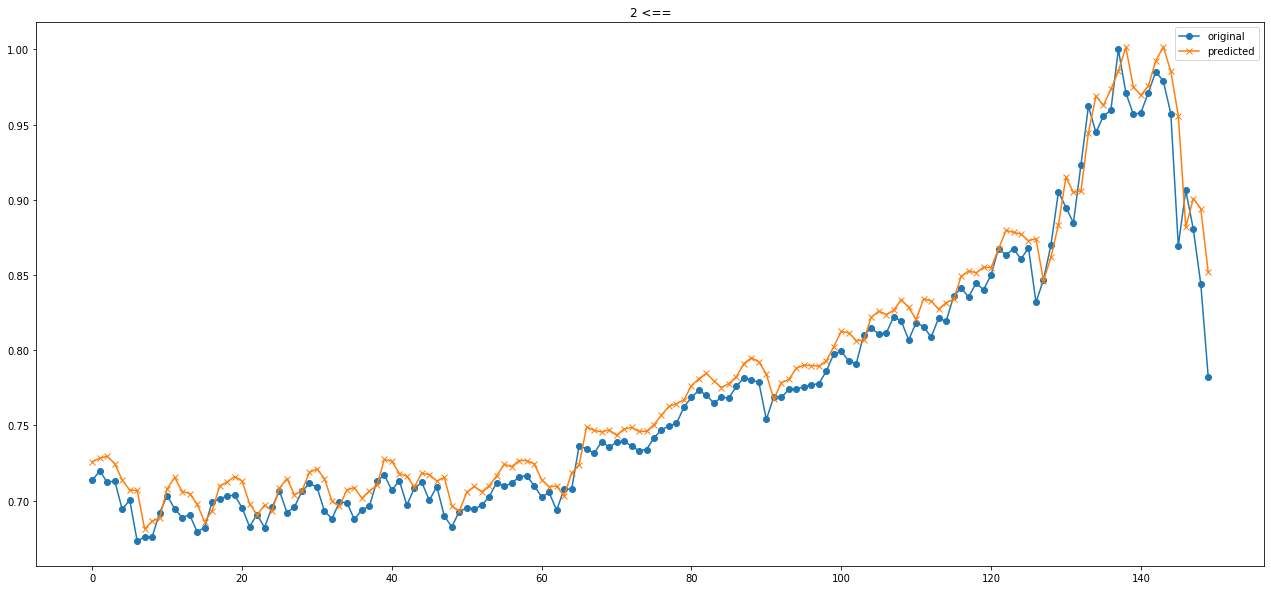

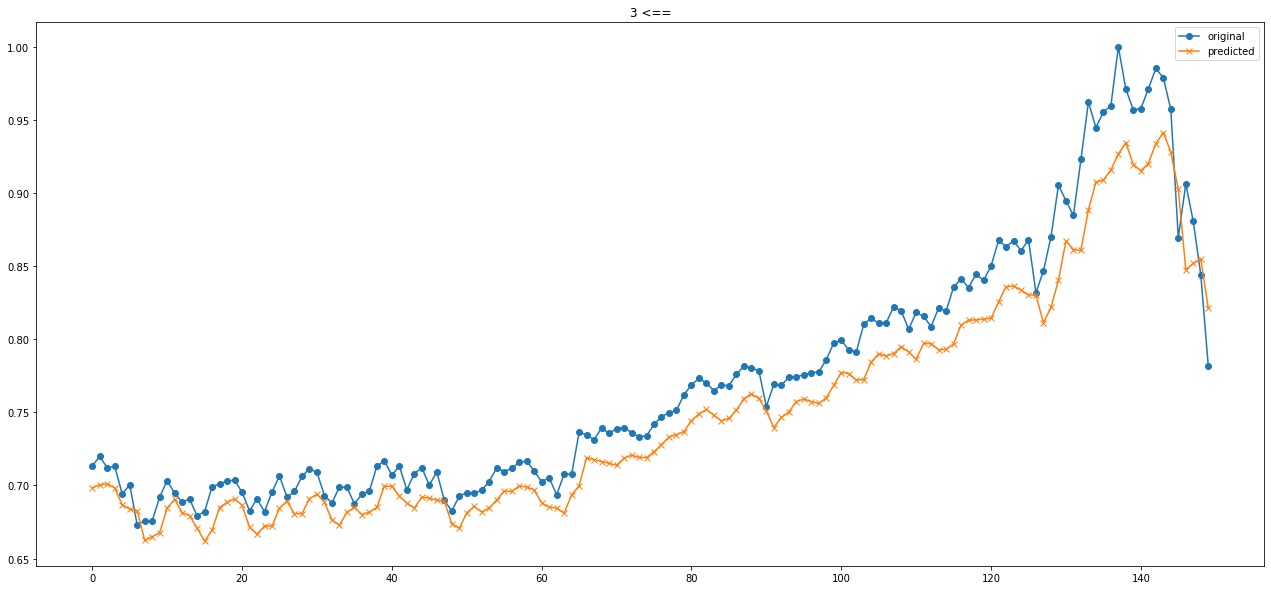

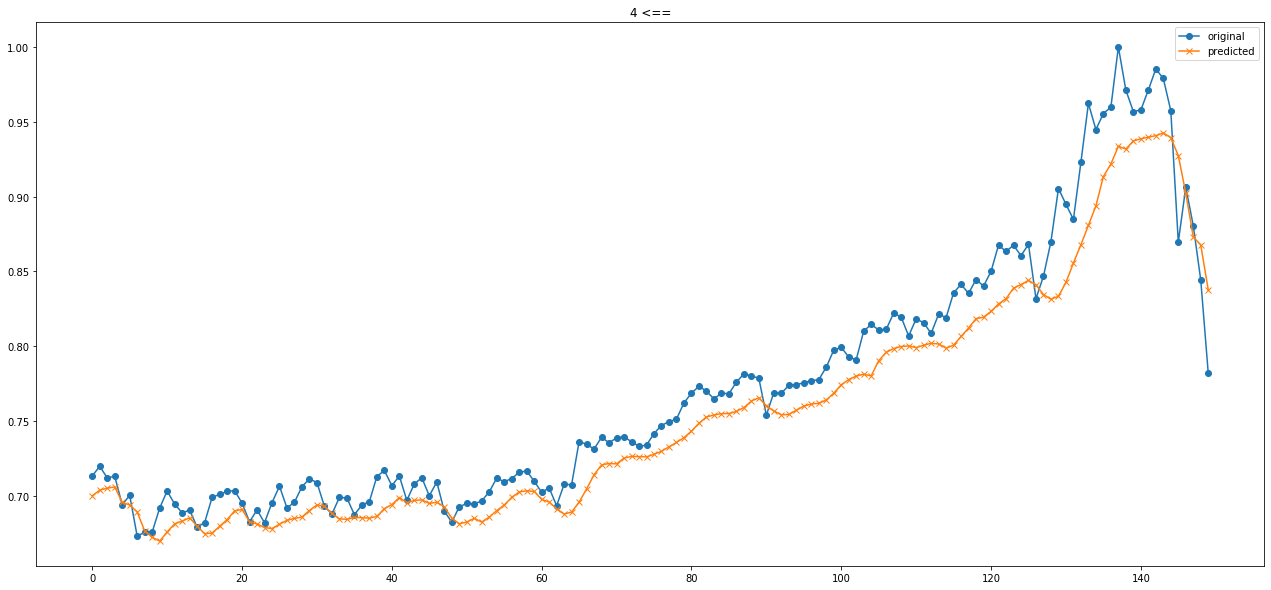

In [47]:
#plot(1, valg1); 
plot(2, valg1);
plot(3, valg1);
plot(4, valg1);